In [1]:
import torch
import torchvision
from torchvision.transforms import Normalize, Resize, ToTensor, Compose
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
from datasets import load_dataset
from transformers import ViTImageProcessor, ViTForImageClassification, Trainer, TrainingArguments, AdamW, get_linear_schedule_with_warmup, TrainerCallback
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from copy import deepcopy


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# Function to compute metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    accuracy = accuracy_score(predictions, labels)
    loss = torch.nn.functional.cross_entropy(torch.tensor(logits), torch.tensor(labels)).item()
    return dict(accuracy=accuracy, loss=loss)

# Function to collate data
def collate_fn(examples):
    pixels = torch.stack([example["pixels"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixels, "labels": labels}

# Plotting loss and accuracy for both validation and training
def plot_metrics(trainer, title_prefix="Model"):
    # Collect training and evaluation metrics
    metrics = trainer.state.log_history

    # Extract validation and training loss and accuracy
    val_loss = [x["eval_loss"] for x in metrics if "eval_loss" in x]
    val_accuracy = [x["eval_accuracy"] for x in metrics if "eval_accuracy" in x]
    train_loss = [x["train_loss"] for x in metrics if "train_loss" in x]
    train_accuracy = [x["train_accuracy"] for x in metrics if "train_accuracy" in x]

    # Make sure all arrays have the same length
    num_epochs = min(len(val_loss), len(train_loss), len(val_accuracy), len(train_accuracy))
    
    val_loss = val_loss[:num_epochs]
    train_loss = train_loss[:num_epochs]
    val_accuracy = val_accuracy[:num_epochs]
    train_accuracy = train_accuracy[:num_epochs]
    
    epochs = range(1, num_epochs + 1)

    # Plot loss for both validation and training
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.plot(epochs, train_loss, label='Training Loss', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{title_prefix} Loss')
    plt.legend()

    # Plot accuracy for both validation and training
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.plot(epochs, train_accuracy, label='Training Accuracy', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'{title_prefix} Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

### Load and Process Data and Model

In [3]:
# Load and preprocess the CIFAR-10 dataset
trainds, testds = load_dataset("cifar10", split=["train[:5000]", "test[:1000]"])
splits = trainds.train_test_split(test_size=0.1)
trainds = splits['train']
valds = splits['test']

id2label = {id:label for id, label in enumerate(trainds.features['label'].names)}
label2id = {label:id for id,label in id2label.items()}

# Load preprocessor
model_name = "google/vit-base-patch16-224"
processor = ViTImageProcessor.from_pretrained(model_name)

# Transform the dataset
mu, sigma = processor.image_mean, processor.image_std
size = processor.size
norm = Normalize(mean=mu, std=sigma)

_transf = Compose([
    Resize((size['height'], size['width'])),
    ToTensor(),
    norm
])

def transf(arg):
    arg['pixels'] = [_transf(image.convert('RGB')) for image in arg['img']]
    return arg

trainds.set_transform(transf)
valds.set_transform(transf)
testds.set_transform(transf)

### Fine Tune Visual Transformer using Hugging Face Trainer Class

In [4]:

# Function to select MPS if available, otherwise CPU
def try_gpu(i=0):
    """Return MPS device if available, otherwise return CPU."""
    if torch.backends.mps.is_available() and torch.backends.mps.is_built():
        return torch.device('mps')
    return torch.device('cpu')

# Set the device
device = try_gpu()
print(f'Device: {device} used for training')
# Fine-tuning process
print("Starting fine-tuning process...")

# Load the model and move it to the selected device (MPS or CPU)
model = ViTForImageClassification.from_pretrained(model_name, num_labels=10, ignore_mismatched_sizes=True, id2label=id2label, label2id=label2id).to(device)

# Freeze lower layers
for param in model.vit.embeddings.parameters():
    param.requires_grad = False
for layer in model.vit.encoder.layer[:8]:  # Freeze first 8 layers
    for param in layer.parameters():
        param.requires_grad = False

class CustomCallback(TrainerCallback):
    
    def __init__(self, trainer) -> None:
        super().__init__()
        self._trainer = trainer
    
    def on_epoch_end(self, args, state, control, **kwargs):
        if control.should_evaluate:
            control_copy = deepcopy(control)
            self._trainer.evaluate(eval_dataset=self._trainer.train_dataset, metric_key_prefix="train")
            return control_copy
        
# Define optimizer and scheduler
total_steps = len(trainds) * 2 // 32  # num_train_epochs * num_batches_per_epoch
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0.1 * total_steps, num_training_steps=total_steps)

# Define Training Arguments
fine_tune_args = TrainingArguments(
    f"fine-tuned-cifar-10",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    num_train_epochs=10,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_dir='logs',
    remove_unused_columns=False
)

# Define trainer for fine-tuning
fine_tune_trainer = Trainer(
    model,
    fine_tune_args,
    train_dataset=trainds,
    eval_dataset=valds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
    # optimizers=(optimizer, scheduler)  # Uncomment if needed
)

# Add custom callback
fine_tune_trainer.add_callback(CustomCallback(fine_tune_trainer))

# Start training
train = fine_tune_trainer.train()
print("\nFine-tuning completed.")


Device: mps used for training
Starting fine-tuning process...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/transformers/training_args.py:1545: Fu

{'train_loss': 0.3292645215988159, 'train_accuracy': 0.9691111111111111, 'train_runtime': 64.5472, 'train_samples_per_second': 69.716, 'train_steps_per_second': 1.1, 'epoch': 1.0}


                                                  
 10%|█         | 141/1410 [02:56<13:55,  1.52it/s]

{'eval_loss': 0.33825308084487915, 'eval_accuracy': 0.974, 'eval_runtime': 7.2775, 'eval_samples_per_second': 68.705, 'eval_steps_per_second': 1.099, 'epoch': 1.0}


                                                    
 20%|██        | 282/1410 [05:48<13:06,  1.43it/s]

{'train_loss': 0.12150198221206665, 'train_accuracy': 0.9846666666666667, 'train_runtime': 65.5174, 'train_samples_per_second': 68.684, 'train_steps_per_second': 1.084, 'epoch': 2.0}


                                                  
 20%|██        | 282/1410 [05:55<13:06,  1.43it/s]

{'eval_loss': 0.1355612725019455, 'eval_accuracy': 0.982, 'eval_runtime': 7.0961, 'eval_samples_per_second': 70.461, 'eval_steps_per_second': 1.127, 'epoch': 2.0}


                                                    
 30%|███       | 423/1410 [08:50<10:43,  1.53it/s]

{'train_loss': 0.06958185136318207, 'train_accuracy': 0.9922222222222222, 'train_runtime': 66.1017, 'train_samples_per_second': 68.077, 'train_steps_per_second': 1.074, 'epoch': 3.0}


                                                  
 30%|███       | 423/1410 [08:58<10:43,  1.53it/s]

{'eval_loss': 0.09392266720533371, 'eval_accuracy': 0.984, 'eval_runtime': 7.5295, 'eval_samples_per_second': 66.406, 'eval_steps_per_second': 1.062, 'epoch': 3.0}


 35%|███▌      | 500/1410 [09:57<11:40,  1.30it/s]  

{'loss': 0.3976, 'grad_norm': 9.801997184753418, 'learning_rate': 1.2907801418439719e-05, 'epoch': 3.55}


                                                  
 40%|████      | 564/1410 [11:53<09:13,  1.53it/s]

{'train_loss': 0.046569183468818665, 'train_accuracy': 0.9951111111111111, 'train_runtime': 68.5693, 'train_samples_per_second': 65.627, 'train_steps_per_second': 1.035, 'epoch': 4.0}


                                                  
 40%|████      | 564/1410 [12:00<09:13,  1.53it/s]

{'eval_loss': 0.07792428135871887, 'eval_accuracy': 0.984, 'eval_runtime': 7.3249, 'eval_samples_per_second': 68.26, 'eval_steps_per_second': 1.092, 'epoch': 4.0}


                                                    
 50%|█████     | 705/1410 [14:56<07:53,  1.49it/s]

{'train_loss': 0.03399240970611572, 'train_accuracy': 0.9966666666666667, 'train_runtime': 66.5828, 'train_samples_per_second': 67.585, 'train_steps_per_second': 1.066, 'epoch': 5.0}


                                                  
 50%|█████     | 705/1410 [15:04<07:53,  1.49it/s]

{'eval_loss': 0.06982241570949554, 'eval_accuracy': 0.982, 'eval_runtime': 7.5241, 'eval_samples_per_second': 66.453, 'eval_steps_per_second': 1.063, 'epoch': 5.0}


                                                    
 60%|██████    | 846/1410 [18:01<06:25,  1.46it/s]

{'train_loss': 0.02623521164059639, 'train_accuracy': 0.9984444444444445, 'train_runtime': 67.3641, 'train_samples_per_second': 66.801, 'train_steps_per_second': 1.054, 'epoch': 6.0}


                                                  
 60%|██████    | 846/1410 [18:08<06:25,  1.46it/s]

{'eval_loss': 0.06583455950021744, 'eval_accuracy': 0.982, 'eval_runtime': 7.451, 'eval_samples_per_second': 67.105, 'eval_steps_per_second': 1.074, 'epoch': 6.0}


                                                    
 70%|███████   | 987/1410 [21:01<04:38,  1.52it/s]

{'train_loss': 0.021248048171401024, 'train_accuracy': 0.9986666666666667, 'train_runtime': 64.8275, 'train_samples_per_second': 69.415, 'train_steps_per_second': 1.095, 'epoch': 7.0}


                                                  
 70%|███████   | 987/1410 [21:08<04:38,  1.52it/s]

{'eval_loss': 0.06357978284358978, 'eval_accuracy': 0.982, 'eval_runtime': 7.1663, 'eval_samples_per_second': 69.771, 'eval_steps_per_second': 1.116, 'epoch': 7.0}


 71%|███████   | 1000/1410 [21:18<07:11,  1.05s/it] 

{'loss': 0.0359, 'grad_norm': 9.50723934173584, 'learning_rate': 5.815602836879432e-06, 'epoch': 7.09}


                                                   
 80%|████████  | 1128/1410 [23:59<03:02,  1.54it/s]

{'train_loss': 0.018157392740249634, 'train_accuracy': 0.9991111111111111, 'train_runtime': 64.9332, 'train_samples_per_second': 69.302, 'train_steps_per_second': 1.093, 'epoch': 8.0}


                                                   
 80%|████████  | 1128/1410 [24:06<03:02,  1.54it/s]

{'eval_loss': 0.06188199669122696, 'eval_accuracy': 0.982, 'eval_runtime': 7.3354, 'eval_samples_per_second': 68.163, 'eval_steps_per_second': 1.091, 'epoch': 8.0}


                                                     
 90%|█████████ | 1269/1410 [26:59<01:31,  1.54it/s]

{'train_loss': 0.016487034037709236, 'train_accuracy': 0.9993333333333333, 'train_runtime': 66.3928, 'train_samples_per_second': 67.778, 'train_steps_per_second': 1.069, 'epoch': 9.0}


                                                   
 90%|█████████ | 1269/1410 [27:07<01:31,  1.54it/s]

{'eval_loss': 0.06086578965187073, 'eval_accuracy': 0.982, 'eval_runtime': 8.0381, 'eval_samples_per_second': 62.204, 'eval_steps_per_second': 0.995, 'epoch': 9.0}


                                                   
100%|██████████| 1410/1410 [30:01<00:00,  1.55it/s]

{'train_loss': 0.01601475104689598, 'train_accuracy': 0.9993333333333333, 'train_runtime': 66.2618, 'train_samples_per_second': 67.912, 'train_steps_per_second': 1.072, 'epoch': 10.0}


                                                   
100%|██████████| 1410/1410 [30:08<00:00,  1.55it/s]

{'eval_loss': 0.0604739636182785, 'eval_accuracy': 0.982, 'eval_runtime': 7.2066, 'eval_samples_per_second': 69.381, 'eval_steps_per_second': 1.11, 'epoch': 10.0}


100%|██████████| 1410/1410 [30:09<00:00,  1.28s/it]

{'train_runtime': 1809.4797, 'train_samples_per_second': 24.869, 'train_steps_per_second': 0.779, 'train_loss': 0.15903953694282694, 'epoch': 10.0}

Fine-tuning completed.


#### Evaluate Model

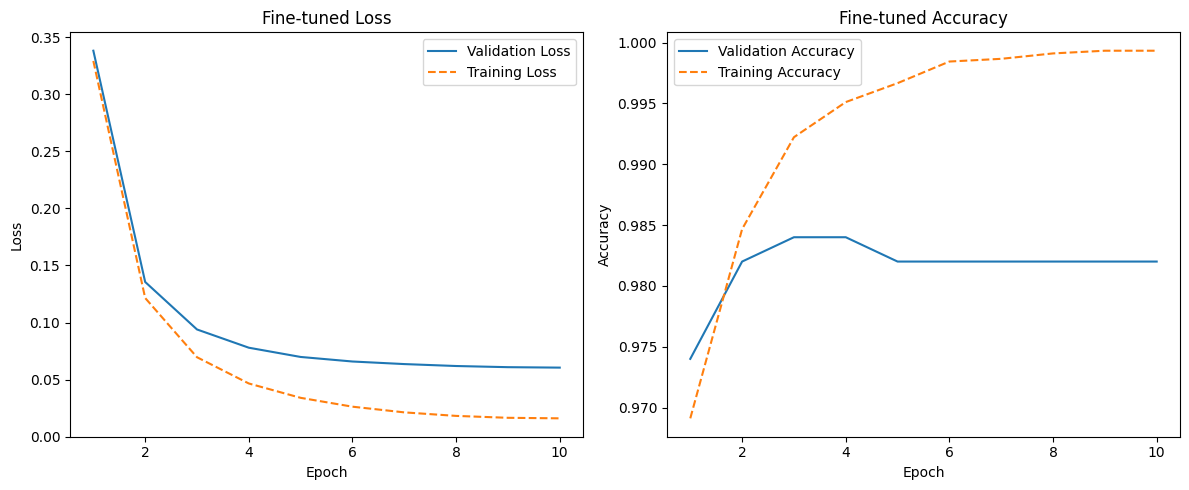

In [7]:
# Plot metrics for fine-tuned model
plot_metrics(fine_tune_trainer, title_prefix="Fine-tuned")

### Plot Attention Maps

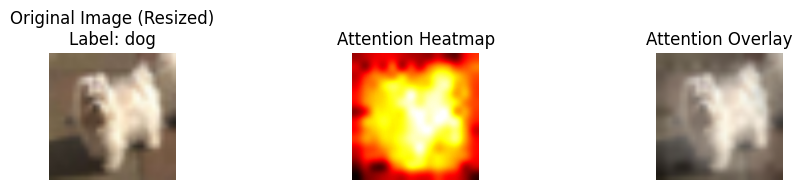

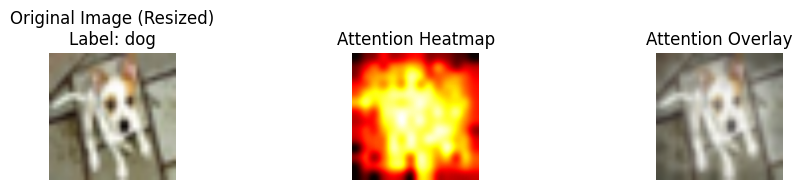

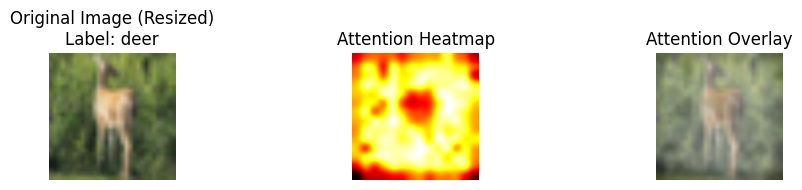

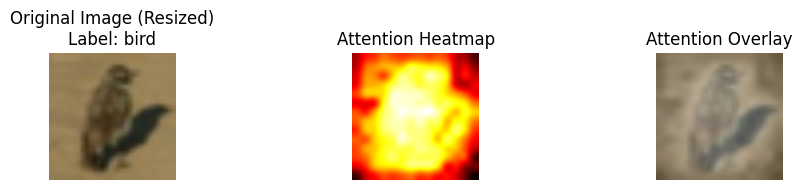

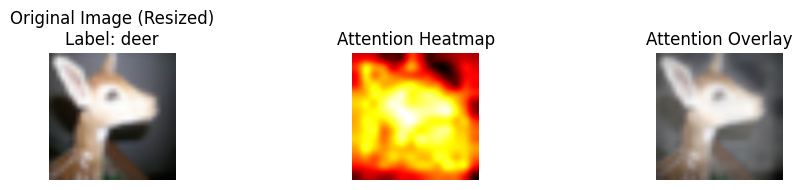

In [11]:
import torch
import torchvision
from torchvision.transforms import Normalize, Resize, ToTensor, Compose
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
from datasets import load_dataset
from transformers import ViTImageProcessor, ViTForImageClassification
import numpy as np

def attention_rollout(attentions):
    rollout = torch.eye(attentions[0].size(-1)).to(attentions[0].device)
    for attention in attentions:
        attention_heads_fused = attention.mean(dim=1)
        attention_heads_fused += torch.eye(attention_heads_fused.size(-1)).to(attention_heads_fused.device)
        attention_heads_fused /= attention_heads_fused.sum(dim=-1, keepdim=True)
        rollout = torch.matmul(rollout, attention_heads_fused)
    return rollout

# Load and preprocess the CIFAR-10 dataset
trainds, testds = load_dataset("cifar10", split=["train[:5000]", "test[:1000]"])
splits = trainds.train_test_split(test_size=0.1)
trainds = splits['train']
valds = splits['test']

# Load a pre-trained ViT model and feature extractor
model_name = 'google/vit-base-patch16-224'  # Changed to a model that expects 224x224 input
processor = ViTImageProcessor.from_pretrained(model_name)
model = ViTForImageClassification.from_pretrained(model_name, attn_implementation='eager')

# CIFAR-10 classes
classes = trainds.features['label'].names

for i in range(5):
    # Process an image
    img = trainds[i]['img']
    label = trainds[i]['label']
    label_name = classes[label]  # Get the label name
    img_resized = img.resize((224, 224), Image.BILINEAR)  # Resize to 224x224
    inputs = processor(images=img_resized, return_tensors="pt")
    outputs = model(**inputs, output_attentions=True)

    # Get attentions and perform rollout
    attentions = outputs.attentions
    rollout = attention_rollout(attentions)

    # Get attention from [CLS] token to all patches
    num_of_patches = rollout.size(-1) - 1
    cls_attention = rollout[0, 1:, 0]
    cls_attention = 1 - cls_attention.reshape(int(np.sqrt(num_of_patches)), int(np.sqrt(num_of_patches)))

    # Detach and convert to numpy
    cls_attention = cls_attention.detach().cpu().numpy()

    # Normalize the attention map
    cls_attention = (cls_attention - cls_attention.min()) / (cls_attention.max() - cls_attention.min())

    # Resize and blur the attention map
    cls_attention_resized = Image.fromarray((cls_attention * 255).astype(np.uint8)).resize((224, 224), resample=Image.BICUBIC)
    cls_attention_resized = cls_attention_resized.filter(ImageFilter.GaussianBlur(radius=2))

    # Convert the attention map to RGBA
    cls_attention_colored = np.array(cls_attention_resized.convert("L"))
    cls_attention_colored = np.stack([cls_attention_colored]*3 + [cls_attention_colored], axis=-1)
    cls_attention_colored_img = Image.fromarray(cls_attention_colored, mode="RGBA")
    cls_attention_colored_img.putalpha(100)  # Adjust alpha for blending

    # Overlay attention map on the original image
    img_rgba = img_resized.convert("RGBA")
    attention_overlay = Image.alpha_composite(img_rgba, cls_attention_colored_img)

    # Visualize the results with a smaller figure size
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 2))  # Reduced the figure size

    ax1.imshow(img_resized)
    ax1.set_title(f"Original Image (Resized)\nLabel: {label_name}")
    ax1.axis('off')

    ax2.imshow(cls_attention_resized, cmap='hot')
    ax2.set_title("Attention Heatmap")
    ax2.axis('off')

    ax3.imshow(attention_overlay)
    ax3.set_title("Attention Overlay")
    ax3.axis('off')

    plt.tight_layout()
    plt.show()

